In [35]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def ReLu(x, derivative=False):
    if(derivative==False):
        return x*(x > 0)
    else:
        return 1*(x > 0)

def Softmax(x):
    x -= np.max(x)
    sm = (np.exp(x).T / np.sum(np.exp(x),axis=1)).T
    return sm

def CreateWeights():
    ##Initialization of the Weights and the Biases with the random gaussian function with mean zeron, and variance between 1/sqtr(num_inputs_layer)
    
    ninputs = 784
    wl1 = 512 ##Number of neurons in the first layer
    wl2 =  128##Number of neurons in the second layer
    nclass = 10 ##Numer of the class, in this case it is the number of the digits.
    
    #layer1
    w1 = np.random.normal(0, ninputs**-0.5, [ninputs,wl1])
    b1 = np.random.normal(0, ninputs**-0.5, [1,wl1])
    
    #Layer2
    w2 = np.random.normal(0, wl1**-0.5, [wl1,wl2])
    b2 = np.random.normal(0, wl1**-0.5, [1,wl2])

    #Layer3
    w3 = np.random.normal(0, wl2**-0.5, [wl2,nclass])
    b3 = np.random.normal(0, wl2**-0.5, [1,nclass])
    
    return [w1,w2,w3,b1,b2,b3]

def Dropout(x, keep_prop):
    mask = np.random.binomial([np.ones_like(x)],(1-keep_prop))[0]  / (1-keep_prop)
    return x*mask

epsilon = 10 ** -3

class BatchNormLayer:

    def __init__(self, dims: int) -> None:
        self.gamma = np.ones((1, dims), dtype="float32")
        self.bias = np.zeros((1, dims), dtype="float32")

        self.running_mean_x = np.zeros(0)
        self.running_var_x = np.zeros(0)

        # forward params
        self.var_x = np.zeros(0)
        self.stddev_x = np.zeros(0)
        self.x_minus_mean = np.zeros(0)
        self.standard_x = np.zeros(0)
        self.num_examples = 0
        self.mean_x = np.zeros(0)
        self.running_avg_gamma = 0.9

        # backward params
        self.gamma_grad = np.zeros(0)
        self.bias_grad = np.zeros(0)

    def update_running_variables(self) -> None:
        is_mean_empty = np.array_equal(np.zeros(0), self.running_mean_x)
        is_var_empty = np.array_equal(np.zeros(0), self.running_var_x)
        if is_mean_empty != is_var_empty:
            raise ValueError("Mean and Var running averages should be "
                             "initilizaded at the same time")
        if is_mean_empty:
            self.running_mean_x = self.mean_x
            self.running_var_x = self.var_x
        else:
            gamma = self.running_avg_gamma
            self.running_mean_x = gamma * self.running_mean_x + \
                                  (1.0 - gamma) * self.mean_x
            self.running_var_x = gamma * self.running_var_x + \
                                 (1. - gamma) * self.var_x

    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
        self.num_examples = x.shape[0]
        if train:
            self.mean_x = np.mean(x, axis=0, keepdims=True)
            self.var_x = np.mean((x - self.mean_x) ** 2, axis=0, keepdims=True)
            self.update_running_variables()
        else:
            self.mean_x = self.running_mean_x.copy()
            self.var_x = self.running_var_x.copy()

        self.var_x += epsilon
        self.stddev_x = np.sqrt(self.var_x)
        self.x_minus_mean = x - self.mean_x
        self.standard_x = self.x_minus_mean / self.stddev_x
        return self.gamma * self.standard_x + self.bias
    
    def backward(self, grad_input: np.ndarray) -> np.ndarray:
        standard_grad = grad_input * self.gamma

        var_grad = np.sum(standard_grad * self.x_minus_mean * -0.5 * self.var_x ** (-3/2),
                          axis=0, keepdims=True)
        stddev_inv = 1 / self.stddev_x
        aux_x_minus_mean = 2 * self.x_minus_mean / self.num_examples

        mean_grad = (np.sum(standard_grad * -stddev_inv, axis=0,
                            keepdims=True) +
                            var_grad * np.sum(-aux_x_minus_mean, axis=0,
                            keepdims=True))

        self.gamma_grad = np.sum(grad_input * self.standard_x, axis=0,
                                 keepdims=True)
        self.bias_grad = np.sum(grad_input, axis=0, keepdims=True)

        return standard_grad * stddev_inv + var_grad * aux_x_minus_mean + \
               mean_grad / self.num_examples

    def apply_gradients(self, learning_rate: float) -> None:
        self.gamma -= learning_rate * self.gamma_grad
        self.bias -= learning_rate * self.bias_grad


In [36]:
BN256=BatchNormLayer(dims=512)

In [37]:
def predict(weights, x, bn=None,keep_prop=0):
    
    w1,w2,w3,b1,b2,b3  = weights 
    
    #1-Hidden Layer
    first = ReLu(x@w1+b1)
    if bn!=None:
        first=bn.forward(first)

    #2-Hidden Layer
    second = ReLu(first@w2+b2)
    second = Dropout(second, keep_prop)
    
    #Output Layer
    return [first, second, Softmax(second@w3+b3)]

def accuracy(output, y):
    hit = 0
    output = np.argmax(output, axis=1)
    y = np.argmax(y, axis=1)
    for y in zip(output, y):
        if(y[0]==y[1]):
            hit += 1

    p = (hit*100)/output.shape[0]
    return p

def log2(x):
    if(x!=0):
        return np.log(x)
    else:
        return -np.inf
    
def log(y):
    return [[log2(nx) for nx in x]for x in y]

def cost(Y_predict, Y_right):
    
    Loss = -np.mean(Y_right*log(Y_predict) + (1-Y_right)*log(1-Y_predict))
    return Loss

def SGD(weights, x, t, outputs, eta, gamma, nabla, bn,cache=None):
    
    w1,w2,w3,b1,b2,b3  = weights
    
    
    if(cache==None):
            vw1 = np.zeros_like(w1)
            vw2 = np.zeros_like(w2)
            vw3 = np.zeros_like(w3)
            vb1 = np.zeros_like(b1)
            vb2 = np.zeros_like(b2)
            vb3 = np.zeros_like(b3)
    else:
        vw1,vw2,vw3,vb1,vb2,vb3 = cache
    
    first, second, y = outputs
   
    w3_delta = (t-y)
    
    w2_error = w3_delta@w3.T

    w2_delta = w2_error * ReLu(second,derivative=True)

    w1_error = w2_delta@w2.T
    w1_delta = w1_error * ReLu(first,derivative=True)
    # print(type(BN256))
    if bn!=None:
        bn.backward(w1_delta)
    
    eta = -eta/x.shape[0]
 
    vw3 = gamma*vw3 + eta * (second.T@w3_delta + nabla*w3)
    vb3 = gamma*vb3 + eta * w3_delta.sum(axis=0)

    vw2 = gamma*vw2 + eta * (first.T@w2_delta + nabla*w2)
    vb2 = gamma*vb2 + eta * w2_delta.sum(axis=0)

    vw1 = gamma*vw1 + eta * (x.T@w1_delta + nabla*w1)
    vb1 = gamma*vb1 + eta * w1_delta.sum(axis=0)
    
    
    w3 -= vw3
    b3 -= vb3

    w2 -= vw2
    b2 -= vb2

    w1 -= vw1
    b1 -= vb1
    
    weights = [w1,w2,w3,b1,b2,b3]
    cache = [vw1,vw2,vw3,vb1,vb2,vb3]
    
    return weights, cache

def one_hot_encode(labels, num_classes):
    """
    使用NumPy实现One-Hot编码

    参数：
    labels：标签列表或数组
    num_classes：类别数量

    返回值：
    one_hot：One-Hot编码表示的矩阵，形状为 (N, num_classes)，N为标签数量
    """
    one_hot=np.eye(num_classes)[labels.reshape(-1)].astype(int)

    return one_hot

In [38]:
epochs=10
batch_size=64
lr=1e-4
alpha = 5e-2
decay = 0
momentum = 0
l2 = 0.001
cache=None
import pandas as pd

x_train=pd.read_csv('digit-recognizer/train.csv').values[:30000,1:]
x_test=pd.read_csv('digit-recognizer/train.csv').values[30000:,1:]
y_train=pd.read_csv('digit-recognizer/train.csv').values[:30000,[0]].reshape(-1,1)
y_test=pd.read_csv('digit-recognizer/train.csv').values[30000:,[0]].reshape(-1,1)

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
scaler = MinMaxScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)
model=CreateWeights()

(30000, 784) (30000, 1) (12000, 784) (12000, 1)


In [39]:

train_loss_list=[]
test_loss_list=[]
train_acc_list=[]
test_acc_list=[]
max_acc=0
min_loss=np.inf
for epoch in range(epochs):
    
    
    train_loss=0
    train_acc=0
    test_loss=0
    test_acc=0
    permutation = np.random.permutation(len(x_train))
    shuffled_X = x_train[permutation, :]
    shuffled_Y = y_train[permutation, :]
    
    train_iterator_len=len(range(0, len(x_train), batch_size))
    for batch_start in range(0, len(x_train), batch_size):
        batch_end = min(batch_start + batch_size, len(x_train))
        batch_X = shuffled_X[batch_start:batch_end,: ]
        batch_Y = shuffled_Y[batch_start:batch_end, :]
        batch_Y=one_hot_encode(batch_Y,num_classes=10)
        
        pred=predict(weights=model,
                     x=batch_X,
                     keep_prop=0.5,
                     bn=BN256)
        loss=cost(pred[-1],batch_Y)
        acc=accuracy(output=pred[-1],
                     y=batch_Y)
        model, cache = SGD(model, batch_X, batch_Y, pred, alpha, momentum, l2, BN256,cache)
        
        # log
        train_loss+=loss
        train_acc+=acc
        
       
    permutation = np.random.permutation(len(x_test))
    shuffled_X = x_test[permutation, :]
    
    shuffled_Y = y_test[permutation, :]
    
    test_iterator_len=len(range(0, len(x_test), batch_size))
    for batch_start in range(0, len(x_test), batch_size):
        batch_end = min(batch_start + batch_size, len(x_test))
        batch_X = shuffled_X[batch_start:batch_end,: ]
        batch_Y = shuffled_Y[batch_start:batch_end, :]
        batch_Y=one_hot_encode(batch_Y,num_classes=10)
        
        pred=predict(weights=model,
                     x=batch_X,
                     keep_prop=0.5,
                     bn=BN256)
        loss=cost(pred[-1],batch_Y)
        acc=accuracy(output=pred[-1],
                     y=batch_Y)
        
        # log
        test_loss+=loss
        test_acc+=acc
    
    train_loss_list.append(train_loss/train_iterator_len)
    train_acc_list.append(train_acc/train_iterator_len)
    test_loss_list.append(test_loss/test_iterator_len)
    test_acc_list.append(test_acc/test_iterator_len)
    
    if test_loss/test_iterator_len<min_loss:
        min_loss=test_loss/test_iterator_len
    if test_acc/test_iterator_len>max_acc:
        max_acc=test_acc/test_iterator_len
        
    # weight decay
    alpha = alpha - (alpha*decay)
    print(f'Epoch:{epoch+1}/{epochs}  | Min Test Average Loss:{min_loss:.4f} | Max Test Average Accuracy:{max_acc:.2f}%  | Min Train Loss:{min(train_loss_list):.4f} | Max Train Accuracy:{max(train_acc_list):.2f}%')

Epoch:1/10  | Min Test Average Loss:0.0697 | Max Test Average Accuracy:87.71%  | Min Train Loss:0.1074 | Max Train Accuracy:79.22%
Epoch:2/10  | Min Test Average Loss:0.0563 | Max Test Average Accuracy:89.59%  | Min Train Loss:0.0609 | Max Train Accuracy:88.96%
Epoch:3/10  | Min Test Average Loss:0.0503 | Max Test Average Accuracy:91.22%  | Min Train Loss:0.0508 | Max Train Accuracy:91.00%
Epoch:4/10  | Min Test Average Loss:0.0442 | Max Test Average Accuracy:92.33%  | Min Train Loss:0.0447 | Max Train Accuracy:91.98%
Epoch:5/10  | Min Test Average Loss:0.0414 | Max Test Average Accuracy:92.69%  | Min Train Loss:0.0394 | Max Train Accuracy:93.09%
Epoch:6/10  | Min Test Average Loss:0.0403 | Max Test Average Accuracy:93.02%  | Min Train Loss:0.0358 | Max Train Accuracy:93.71%
Epoch:7/10  | Min Test Average Loss:0.0372 | Max Test Average Accuracy:93.74%  | Min Train Loss:0.0332 | Max Train Accuracy:94.21%
Epoch:8/10  | Min Test Average Loss:0.0352 | Max Test Average Accuracy:93.88%  | Mi

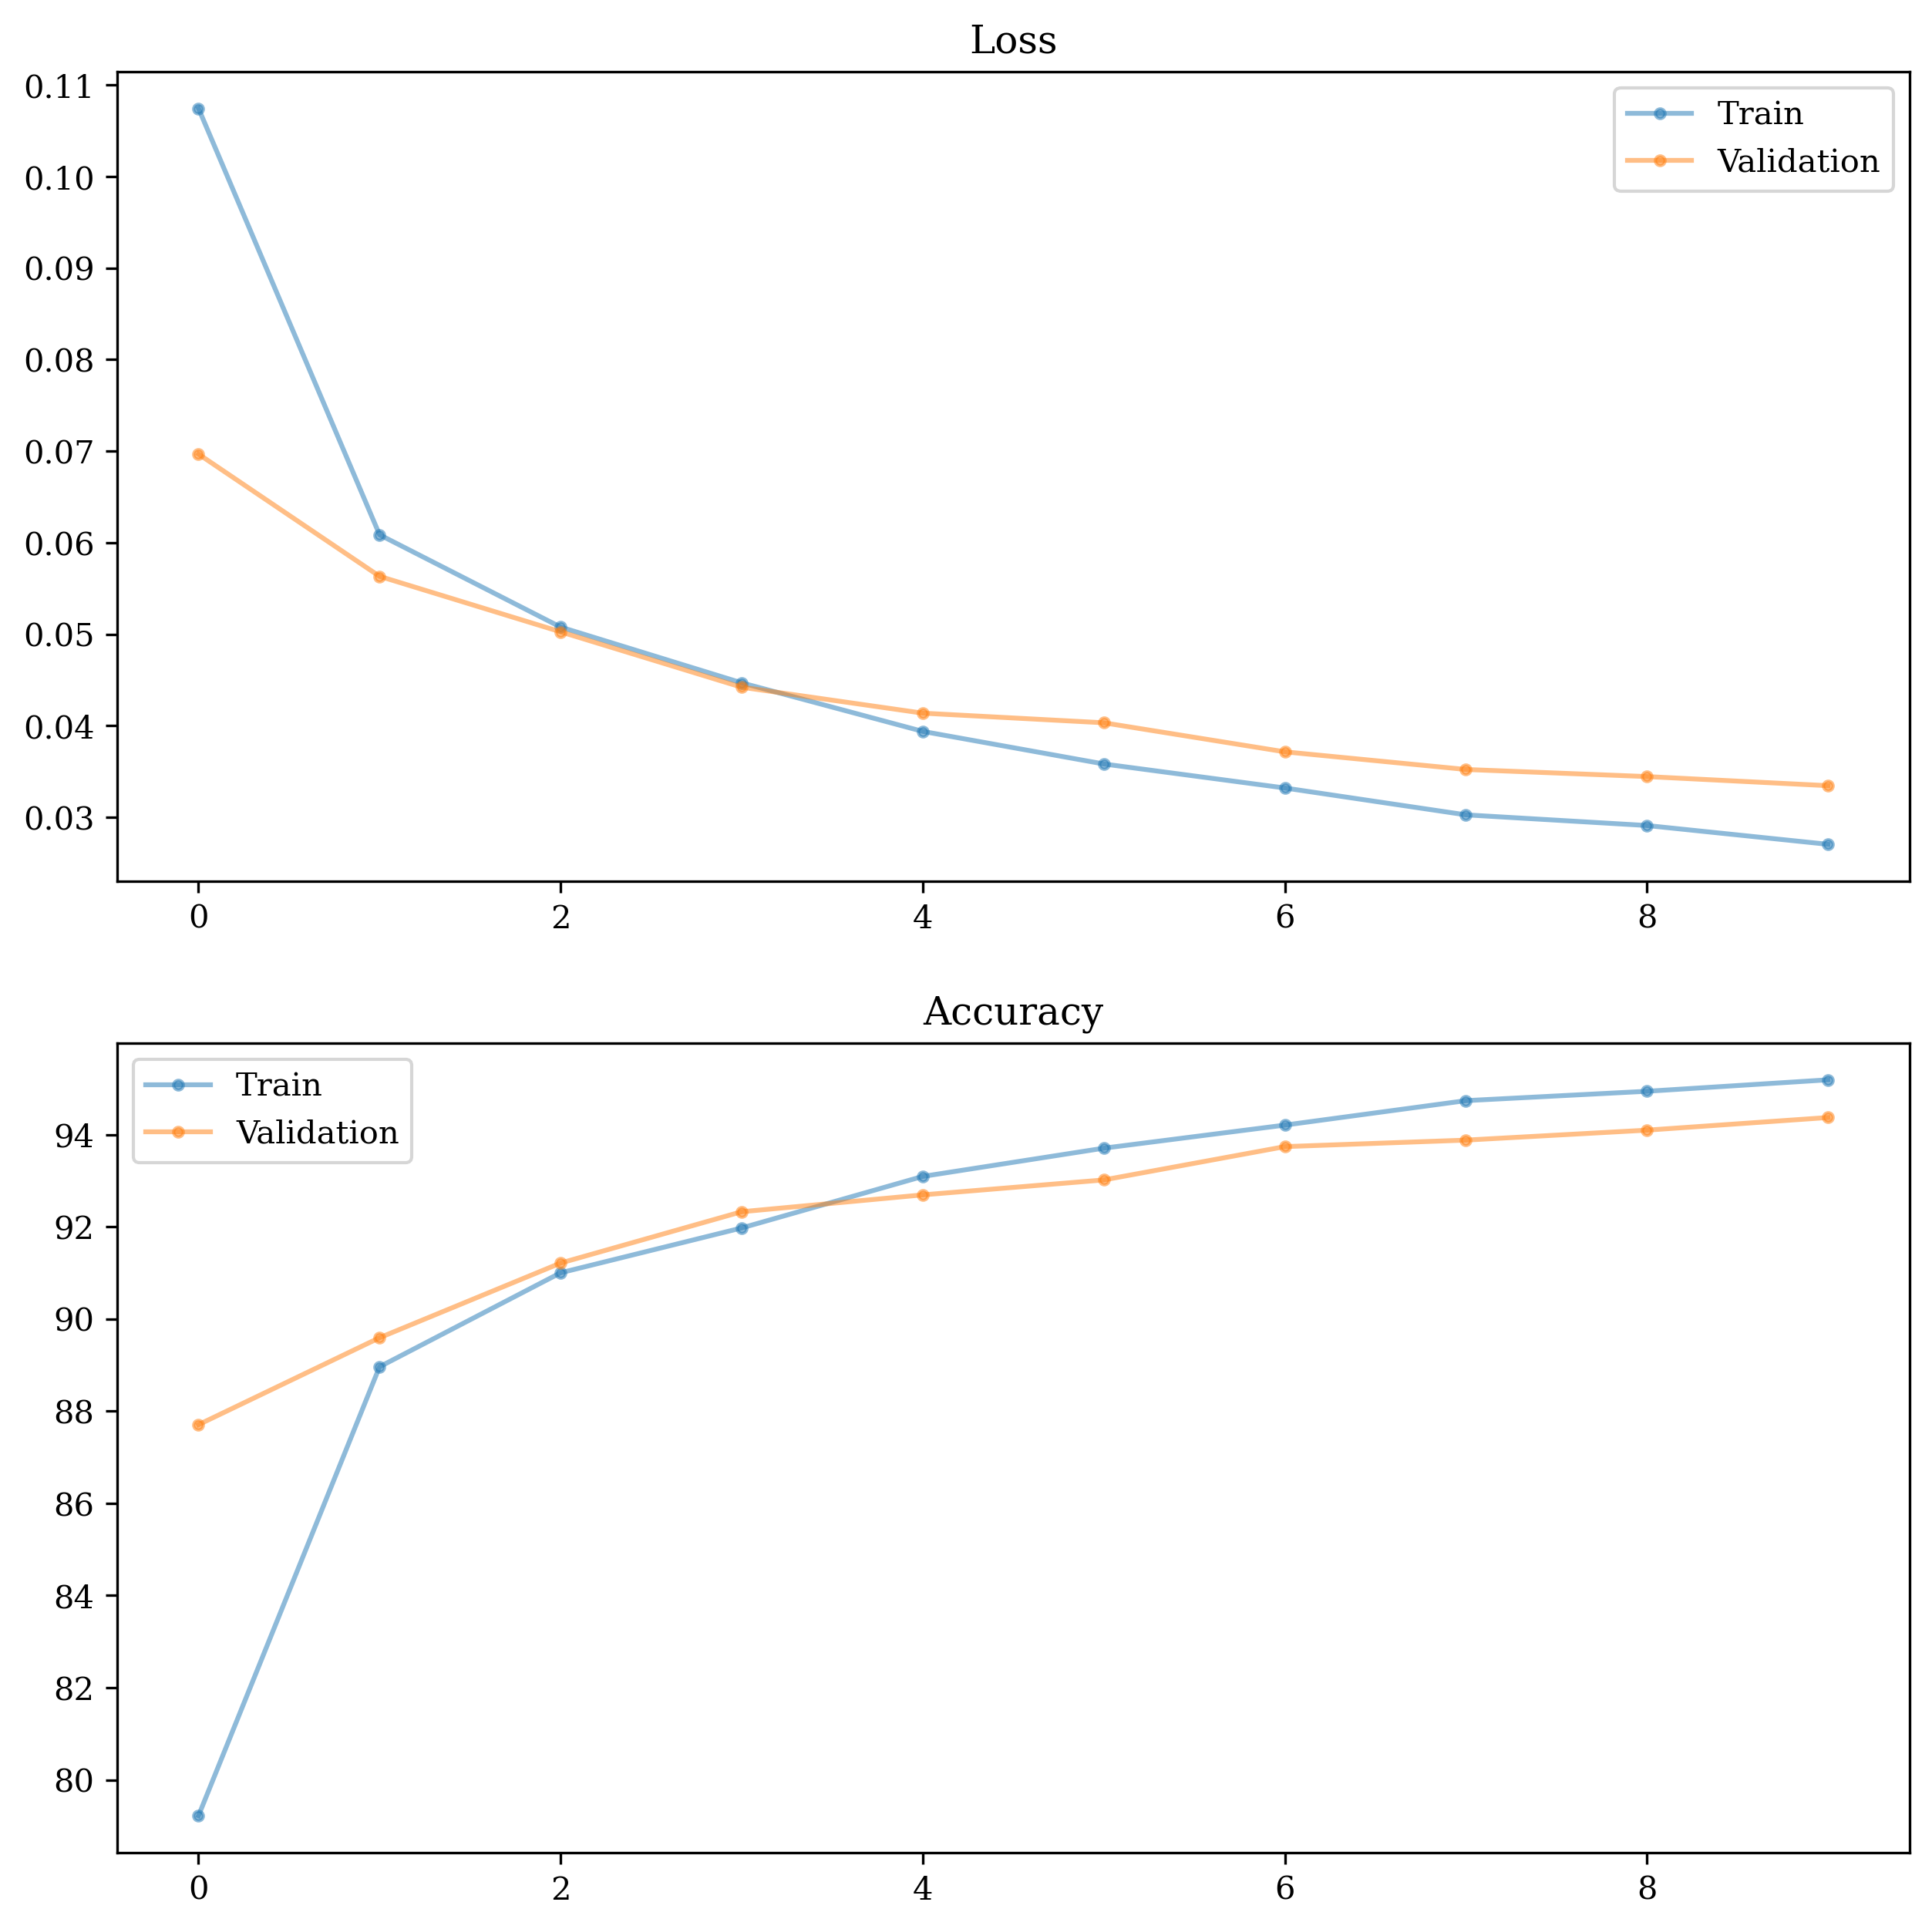

In [43]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

plt.figure(figsize=(10,10),dpi=300)

plt.subplot(211)
plt.title('Loss')
plt.plot(train_loss_list,alpha=0.5,marker='.',label='Train')
plt.plot(test_loss_list,alpha=0.5,marker='.',label='Validation')
plt.legend()
plt.subplot(212)
plt.title('Accuracy')
plt.plot(train_acc_list,alpha=0.5,marker='.',label='Train')
plt.plot(test_acc_list,alpha=0.5,marker='.',label='Validation')
plt.legend()
plt.savefig('mnist-log.jpg')